In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis
from regions import CircleSkyRegion
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    GaussianSpatialModel,
    SkyModel,
    Models,
    PointSpatialModel,
    FoVBackgroundModel,
)
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.modeling import Fit
from gammapy.maps import Map
from scipy.stats import norm
from gammapy.data import Observation
from gammapy.datasets import MapDataset
from gammapy.estimators import ExcessMapEstimator

In [3]:
import scipy.stats as stats
import math
import statistics
import os

In [4]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [5]:
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


In [6]:
# Define the observation parameters (typically the observation duration and the pointing position):
livetime = 1.0 * u.hr
pointing = SkyCoord(141.409467, 40.566962, unit="deg", frame="galactic")

In [7]:
# Define map geometry for binned simulation
energy_reco = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(141.409467, 40.566962),
    binsz=0.02,
    width=(3, 3),
    frame="galactic",
    axes=[energy_reco],
)
# It is usually useful to have a separate binning for the true energy axis
energy_true = MapAxis.from_edges(
    np.logspace(-1.5, 1.5, 30), unit="TeV", name="energy", interp="log"
)

empty = MapDataset.create(geom, name="dataset-simu")

In [8]:
# Define sky model to used simulate the data.
# Here we use a Gaussian spatial model and a Power Law spectral model.
spatial_model = PointSpatialModel(
    lon_0="141.409467 deg", lat_0="40.566962 deg", frame="galactic"
)
spectral_model = PowerLawSpectralModel(
    index=2.22, amplitude="1.289e-12 cm-2 s-1 TeV-1", reference="1 TeV"
)
model_simu = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    name="model-simu",
)

bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")

models = Models([model_simu, bkg_model])
print(models)

Models

Component 0: SkyModel

  Name                      : model-simu
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   2.220              
    amplitude               :   1.29e-12  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lon_0                   : 141.409  deg         
    lat_0                   :  40.567  deg         

Component 1: FoVBackgroundModel

  Name                      : dataset-simu-bkg
  Datasets names            : ['dataset-simu']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                    :   1.000              
    tilt         (frozen)   :   0.000              
    reference    (frozen)   :   1.000  TeV         




In [9]:
# Create an in-memory observation
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51544.04
	duration          : 3600.00 s
	pointing (icrs)   : 149.0 deg, 69.7 deg

	deadtime fraction : 0.0%



In [10]:
# Make the MapDataset
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])

maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=3.5 * u.deg)

dataset = maker.run(empty, obs)
dataset = maker_safe_mask.run(dataset, obs)
print(dataset)

MapDataset
----------

  Name                            : dataset-simu 

  Total counts                    : nan 
  Total background counts         : 27108.70
  Total excess counts             : nan

  Predicted counts                : 27108.70
  Predicted background counts     : 27108.70
  Predicted excess counts         : nan

  Exposure min                    : 5.12e+08 m2 s
  Exposure max                    : 1.30e+10 m2 s

  Number of total bins            : 0 
  Number of fit bins              : 202500 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




In [11]:
# Add the model on the dataset and Poission fluctuate
dataset.models = models
dataset.fake(random_state=42)
# Do a print on the dataset - there is now a counts maps
print(dataset)

MapDataset
----------

  Name                            : dataset-simu 

  Total counts                    : 27272 
  Total background counts         : 27108.70
  Total excess counts             : 163.30

  Predicted counts                : 27341.10
  Predicted background counts     : 27108.70
  Predicted excess counts         : 232.40

  Exposure min                    : 5.12e+08 m2 s
  Exposure max                    : 1.30e+10 m2 s

  Number of total bins            : 202500 
  Number of fit bins              : 202500 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 116588.76

  Number of models                : 2 
  Number of parameters            : 8
  Number of free parameters       : 5

  Component 0: SkyModel
  
    Name                      : model-simu
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Parameters:
      

In [12]:
# To plot, eg, counts:
dataset.counts.smooth(0.05 * u.deg).plot_interactive(
    add_cbar=True, stretch="linear"
)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

In [13]:
dataset.background.smooth(0.05 * u.deg).plot_interactive(
    add_cbar=True, stretch="linear"
)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

In [14]:
dataset.excess.smooth(0.05 * u.deg).plot_interactive(
    add_cbar=True, stretch="linear"
)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

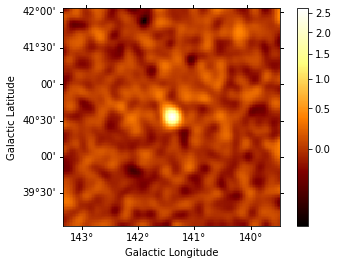

In [15]:
excess = dataset.excess.sum_over_axes()
excess.smooth("0.06 deg").plot(stretch="sqrt", add_cbar=True);

In [16]:
dataset1 = dataset.copy(name = 'dataset-simu')

In [17]:
dataset1.models = bkg_model

In [18]:
print(dataset1)

MapDataset
----------

  Name                            : dataset-simu 

  Total counts                    : 27272 
  Total background counts         : 27108.70
  Total excess counts             : 163.30

  Predicted counts                : 27108.70
  Predicted background counts     : 27108.70
  Predicted excess counts         : 0.00

  Exposure min                    : 5.12e+08 m2 s
  Exposure max                    : 1.30e+10 m2 s

  Number of total bins            : 202500 
  Number of fit bins              : 202500 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 117231.53

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : dataset-simu-bkg
    Datasets names            : ['dataset-simu']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
     

In [19]:
print(dataset1.models)

DatasetModels

Component 0: FoVBackgroundModel

  Name                      : dataset-simu-bkg
  Datasets names            : ['dataset-simu']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                    :   1.000              
    tilt         (frozen)   :   0.000              
    reference    (frozen)   :   1.000  TeV         




In [20]:
# Using a convolution radius of 0.04 degrees
estimator = ExcessMapEstimator(0.04 * u.deg, selection_optional=[])
lima_maps = estimator.run(dataset1)

In [21]:
significance_map = lima_maps["sqrt_ts"]
excess_map = lima_maps["excess"]

(<Figure size 720x720 with 4 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7f75e5900cf8>)

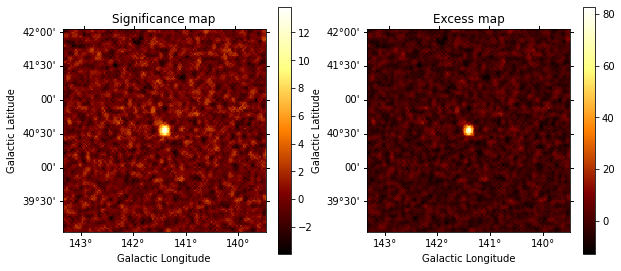

In [22]:
# We can plot the excess and significance maps
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(221, projection=significance_map.geom.wcs)
ax2 = plt.subplot(222, projection=excess_map.geom.wcs)

ax1.set_title("Significance map")
significance_map.plot(ax=ax1, add_cbar=True)

ax2.set_title("Excess map")
excess_map.plot(ax=ax2, add_cbar=True)

In [23]:
models_fit = models.copy()

In [24]:
# We do not want to fit the background in this case, so we will freeze the parameters
models_fit["dataset-simu-bkg"].spectral_model.norm.frozen = True
models_fit["dataset-simu-bkg"].spectral_model.tilt.frozen = True

In [25]:
dataset.models = models_fit
print(dataset.models)

DatasetModels

Component 0: SkyModel

  Name                      : model-simu
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   2.220              
    amplitude               :   1.29e-12  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lon_0                   : 141.409  deg         
    lat_0                   :  40.567  deg         

Component 1: FoVBackgroundModel

  Name                      : dataset-simu-bkg
  Datasets names            : ['dataset-simu']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm         (frozen)   :   1.000              
    tilt         (frozen)   :   0.000              
    reference    (frozen)   :   1.000  TeV         




In [26]:
print(dataset)

MapDataset
----------

  Name                            : dataset-simu 

  Total counts                    : 27272 
  Total background counts         : 27108.70
  Total excess counts             : 163.30

  Predicted counts                : 27341.10
  Predicted background counts     : 27108.70
  Predicted excess counts         : 232.40

  Exposure min                    : 5.12e+08 m2 s
  Exposure max                    : 1.30e+10 m2 s

  Number of total bins            : 202500 
  Number of fit bins              : 202500 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 116588.76

  Number of models                : 2 
  Number of parameters            : 8
  Number of free parameters       : 4

  Component 0: SkyModel
  
    Name                      : model-simu
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Parameters:
      

In [27]:
%%time
fit = Fit([dataset])
result = fit.run(optimize_opts={"print_level": 1})

------------------------------------------------------------------
| FCN = 1.166E+05               |     Ncalls=100 (100 total)     |
| EDM = 9.97E-07 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
CPU times: user 3.98 s, sys: 63.8 ms, total: 4.05 s
Wall time: 4.03 s


In [28]:
print(result)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 100
	total stat : 116586.43



In [29]:
result.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
index,2.2510e+00,,nan,nan,False,6.683e-02
amplitude,1.3742e-12,cm-2 s-1 TeV-1,nan,nan,False,1.101e-13
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00
lon_0,1.4141e+02,deg,nan,nan,False,4.066e-03
lat_0,4.0570e+01,deg,-9.000e+01,9.000e+01,False,3.132e-03
norm,1.0000e+00,,nan,nan,True,0.000e+00
tilt,0.0000e+00,,nan,nan,True,0.000e+00
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00


In [30]:
# Using a convolution radius of 0.04 degrees
estimator = ExcessMapEstimator(0.04 * u.deg, selection_optional=[])
lima_maps = estimator.run(dataset)

In [31]:
significance_map = lima_maps["sqrt_ts"]
excess_map = lima_maps["excess"]

(<Figure size 720x720 with 4 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7f75e5ddf438>)

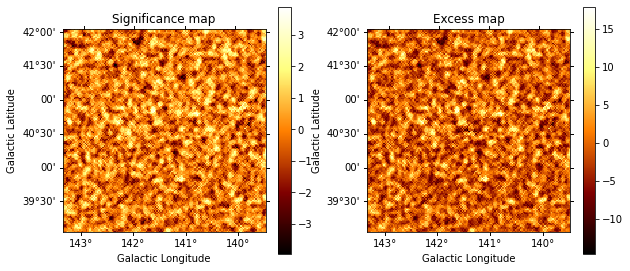

In [32]:
# We can plot the excess and significance maps
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(221, projection=significance_map.geom.wcs)
ax2 = plt.subplot(222, projection=excess_map.geom.wcs)

ax1.set_title("Significance map")
significance_map.plot(ax=ax1, add_cbar=True)

ax2.set_title("Excess map")
excess_map.plot(ax=ax2, add_cbar=True)